<a href="https://colab.research.google.com/github/DomingosLemos/Deploy-cnn-test/blob/main/Copy_of_DLNN_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Os código seguinte são lixo para apagar.
Serviram para testes

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.222182425999989
GPU (s):
0.038368724999997994
GPU speedup over CPU: 83x


# Importar as livrarias necessárias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#models
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

In [5]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
        plt.plot(epochs, val_acc, 'b', color='red', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

### Fazer amount do google drive onde temos um zip com totalidade das imagens

### Descompactar imagens para pastas

In [8]:
!7z x /content/drive/MyDrive/EDSA/images.zip -o/content/images


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/EDSA/                                      1 file, 5132666035 bytes (4895 MiB)

Extracting archive: /content/drive/MyDrive/EDSA/images.zip
  4% 4096 Open              --
Path = /content/drive/MyDrive/EDSA/images.zip
Type = zip
Physical Size = 5132666035
64-bit = +

  0%      0% 662 - apple_pie/3277458.jpg                                  1% 1183 - baby_back_ribs/1615155.jpg                                        1% 1749 - baby_back_ribs/3724591.jpg

### Fazer o Split das imagens
Colocar:
* content/output/train com 70% (700 imagens em cada pasta)
* content/output/val com 20% (200 imagens em cada pasta)
* content/output/test com 10% (100 imagens em cada pasta)



In [9]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/images', output="output", seed=1337, ratio=(.7, .2, .1)) 

Copying files: 101000 files [02:34, 652.54 files/s]


### Obter os dados

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(directory="/content/output/train/",
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(64,64),
                                                    seed=42)

valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator=valid_datagen.flow_from_directory(directory="/content/output/val/", 
                                                  batch_size=64, 
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(64,64),
                                                  seed=42)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator=test_datagen.flow_from_directory(directory="/content/output/test/", 
                                                  batch_size=64,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(64,64),
                                                  seed=42)



Found 70700 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [ ]:
'''
train_datagen = ImageDataGenerator(
                                    samplewise_center = True,
                                    samplewise_std_normalization = True,
                                    rescale = 1./255.,
                                    rotation_range = 40, 
                                    width_shift_range = 0.2, 
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
'''

### Criar o modelo baseline
Modelo composto por duas camadas de Convencional 2D e MaxPooling 2G com 64 neurónios cada. No final, no MLP, colocámos duas dense layers com activation = 'relu' e para output o softmax para distribuir por todas as categorias com 100% no total.   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import maxnorm

X_train, y_train = train_generator.next()
#Input Layer
baseline_model = Sequential()

baseline_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
baseline_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

baseline_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

'''
baseline_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))


baseline_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
'''

# MLP - input layer:
baseline_model.add(Flatten())
# MLP - hidden layer:
##baseline_model.add(Dense(4096, activation='relu',kernel_constraint=maxnorm(3)))
##baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(256, activation='relu',kernel_constraint=maxnorm(3)))
baseline_model.add(Dropout(0.2))

# MLP - output layer:
baseline_model.add(Dense(y_train.shape[1], activation='softmax'))

# Check built model:
baseline_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               3211520   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

### Compilação do modelo
Neste caso foi usado um optimizer 'adam' com learning rate de 0.1% e usou-se a métrica de accurancy para avaliar 

In [ ]:
opt = optimizers.Adam(lr=0.001)

baseline_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [ ]:
early_stop = EarlyStopping(patience=30, monitor='val_loss', mode='min', restore_best_weights=True)


history_baseline_model = baseline_model.fit_generator(train_generator,
                              steps_per_epoch=160, #steps_per_epoch,
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=10, #validation_steps,
                              callbacks=[early_stop],
                              shuffle= True
                             )

baseline_model.save('food_baseline_model.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
160/160 [==============================] - 54s 334ms/step - loss: 4.6191 - acc: 0.0107 - val_loss: 4.5932 - val_acc: 0.0188
Epoch 2/100
160/160 [==============================] - 49s 305ms/step - loss: 4.5594 - acc: 0.0199 - val_loss: 4.4068 - val_acc: 0.0562
Epoch 3/100
160/160 [==============================] - 46s 290ms/step - loss: 4.4047 - acc: 0.0429 - val_loss: 4.2966 - val_acc: 0.0500
Epoch 4/100
160/160 [==============================] - 45s 279ms/step - loss: 4.2537 - acc: 0.0634 - val_loss: 4.1716 - val_acc: 0.0703
Epoch 5/100
160/160 [==============================] - 44s 273ms/step - loss: 4.1667 - acc: 0.0716 - val_loss: 4.1435 - val_acc: 0.0766
Epoch 6/100
160/160 [==============================] - 42s 265ms/step - loss: 4.0888 - acc: 0.0810 - val_loss: 4.0456 - val_acc: 0.0750
Epoch 7/100
160/160 [==============================] - 42s 261ms/step - loss: 4.0338 - acc: 0.0906 - val_loss: 3.9425 - val_acc: 0.1078
Epoch 8/100
160/160 [===========================

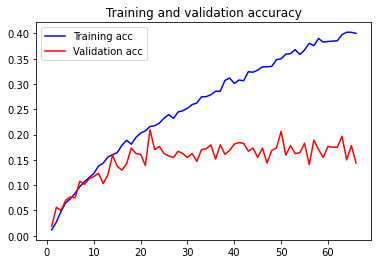

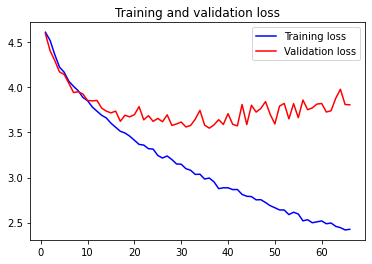

In [ ]:
#Plotting training results
plot_results(history_baseline_model)

In [ ]:
print('Test scores for baseline model:')
baseline_model.evaluate(test_generator, steps=60)

Test scores for baseline model:
60/60 [==============================] - 19s 314ms/step - loss: 3.6484 - acc: 0.1635


[3.648407459259033, 0.16354165971279144]

## VGG-16 model

Como temos um dataset pequeno para cada categoria (700 imagens) vamos usar o "Image Augmentation" para aumentar um pouco o tamanho do nosso dataset

In [11]:
# Add our data-augmentation parameters to ImageDataGenerator and get data
train_datagen_VGG = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
val_datagen_VGG = ImageDataGenerator( rescale = 1.0/255. )

In [14]:
# Flow training images in batches of 20 using train_datagen_VGG generator
train_generator = train_datagen_VGG.flow_from_directory(directory="/content/output/train/", batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using val_datagen_VGG generator
validation_generator = val_datagen_VGG.flow_from_directory( directory="/content/output/val/",  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 70700 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [15]:
#Loading the Base Model

from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
    include_top = False, # Leave out the last fully connected layer
    weights = 'imagenet')


58892288/58889256 [==============================] - 0s 0us/step


In [16]:
gc.collect()

426

In [17]:
#Since we don’t have to train all the layers, we make them non_trainable
for layer in base_model.layers:
    layer.trainable = False

In [18]:
#Compile and Fit
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(101, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])


In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 4.9556 - acc: 0.0077

## Inception

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen_Inception = ImageDataGenerator(rescale = 1./255., 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

val_datagen_Inception = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
#Training and Validation Generators
train_generator = train_datagen_Inception.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (150, 150))
validation_generator = val_datagen_Inception.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'categorical', target_size = (150, 150))


In [ ]:
#Loading the Base Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [ ]:
gc.collect()

1005

In [ ]:
#Compile and Fit
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(101, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


## ResNet50

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen_ResNet50 = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

val_datagen_ResNet50 = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen_ResNet50.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

validation_generator = val_datagen_ResNet50.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))


In [ ]:
#Import the base model
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [ ]:
gc.collect()

1005

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#Build and Compile the Model

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(101, activation='softmax'))

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
#Fitting the model
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

## EfficientNet

In [ ]:
import efficientnet.keras as efn

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen_EfficientNet = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

val_datagen_EfficientNet = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen_EfficientNet.flow_from_directory(train_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

validation_generator = val_datagen_EfficientNet.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

In [ ]:
#Loading the Base Model

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [ ]:
gc.collect()

1005

In [ ]:
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#Build the model

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(101, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

In [ ]:
#Compile and Fit

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


### Temas:

* rever o reshape das imagens (não sei se deve ser igual para todas)
* Experiências com a baseline (já tens)
* testar o código do modelo pré treinado
  * penso que não é necessário coletar os dados em todos os modelos


Amanhã testo os modelos.


# FIM DE CÓDIGO

In [ ]:
gc.collect()

1005

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_callback = ModelCheckpoint('InceptionNet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit_generator(train_generator,
                            validation_data=valid_generator,
                            epochs=10,
                            workers=0,
                            use_multiprocessing=False, 
                            callbacks=[early_stopping_callback, checkpoint_callback])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1263/1263 [==============================] - 1739s 1s/step - loss: 2.8844 - accuracy: 0.3382 - val_loss: 2.6619 - val_accuracy: 0.3891

Epoch 00001: val_loss improved from inf to 2.66189, saving model to InceptionNet.h5
Epoch 2/10
1263/1263 [==============================] - 1675s 1s/step - loss: 1.4509 - accuracy: 0.6439 - val_loss: 2.6808 - val_accuracy: 0.4057

Epoch 00002: val_loss did not improve from 2.66189
Epoch 3/10
1263/1263 [==============================] - 1638s 1s/step - loss: 1.1333 - accuracy: 0.7240 - val_loss: 1.8525 - val_accuracy: 0.5699

Epoch 00003: val_loss improved from 2.66189 to 1.85251, saving model to InceptionNet.h5
Epoch 4/10
1263/1263 [==============================] - 1615s 1s/step - loss: 0.9297 - accuracy: 0.7748 - val_loss: 2.3600 - val_accuracy: 0.4794

Epoch 00004: val_loss did not improve from 1.85251
Epoch 5/10
1263/1263 [==============================] - 1600s 1s/step - loss: 0.7756 - accuracy: 0.8156 - val_loss: 1.8512 - val_accuracy:

In [ ]:
train_datagen = ImageDataGenerator(#data_format='channels_first',
                                  validation_split=0.2,
                                  samplewise_center = True,
                                  samplewise_std_normalization = True,rescale = 1.0/255.)

train_datageno = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory="/content/images",
                                                    subset="training",
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    target_size=(224,224),
                                                    seed=42)

valid_generator=train_datagen.flow_from_directory(directory="/content/images",
                                                  subset="validation",
                                                  batch_size=20,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224,224),
                                                  seed=42)



Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
train_datageno.fit(train_generator)

In [ ]:
train_generator

valid_generator

In [ ]:
#IMAGE AUGMENTATION

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
#TRAINING

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory="/content/output/train", batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(directory="/content/output/val",  batch_size = 20, class_mode = 'categorical', target_size = (224, 224))

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
#NOVO PROJETO

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','pizza','omelette']
src_train = '/content/output/train'
dest_train = '/content/output/train_mini'
src_test = '/content/output/val'
dest_test = '/content/output/val_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find /content/output/train_mini -type d -or -type f -printf '.' | wc -c



Total number of samples in train folder
2400


In [ ]:


print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)



Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find /content/output/val_mini -type d -or -type f -printf '.' | wc -c



Total number of samples in test folder
600


In [ ]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = '/content/output/train_mini'
validation_data_dir = '/content/output/val_mini'
nb_train_samples = 2400 #75750
nb_validation_samples = 600 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
150/150 [==============================] - 74s 442ms/step - loss: 1.1282 - accuracy: 0.4067 - val_loss: 0.8111 - val_accuracy: 0.6959

Epoch 00001: val_loss improved from inf to 0.81108, saving model to best_model_3class.hdf5
Epoch 2/30
150/150 [==============================] - 65s 432ms/step - loss: 0.8120 - accuracy: 0.6959 - val_loss: 0.6171 - val_accuracy: 0.7973

Epoch 00002: val_loss improved from 0.81108 to 0.61714, saving model to best_model_3class.hdf5
Epoch 3/30
150/150 [==============================] - 65s 433ms/step - loss: 0.6302 - accuracy: 0.7828 - val_loss: 0.4980 - val_accuracy: 0.8429

Epoch 00003: val_loss improved from 0.61714 to 0.49803, saving model to best_model_3class.hdf5
Epoch 4/30
150/150 [==============================] - 65s 434ms/step - loss: 0.5057 - accuracy: 0.8249 - val_loss: 0.4307 - val_accuracy: 0.8530

Epoch 00004: val_loss improved from 0.49803 to 0.43072, saving model to best_model_3class.hdf5
Epoch 5/30
150/150 [====================

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

baseline_model = Sequential()

baseline_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(299, 299, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model.add(Flatten())
# MLP - hidden layer:
baseline_model.add(Dense(128, activation='relu'))
# MLP - output layer:
baseline_model.add(Dense(101, activation='softmax'))

# Check built model:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 170528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               21827712  
_________________________________________________________________
dense_1 (Dense)              (None, 101)               1

In [ ]:
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Common attributes:
steps_per_epoch = 10
epochs = 1000
validation_steps = 10
patience=30
shuffle=True

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator=train_datagen.flow_from_directory(
                   
                    directory="/content/output/train",
                    batch_size=100,
                    seed=55551,
                    shuffle=True,
                    
                    class_mode="categorical",
                    target_size=(299,299))

valid_generator=train_datagen.flow_from_directory(
                    
                    directory="/content/output/val",
                    batch_size=100,
                    seed=55551,
                    shuffle=True,
                  
                    class_mode="categorical",
                    target_size=(299,299))

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)

history_baseline_model = baseline_model.fit_generator(train_generator,
                                                      steps_per_epoch=steps_per_epoch,
                                                      validation_data=valid_generator,
                                                      validation_steps=validation_steps,
                                                      epochs=epochs,
                                                      callbacks=[early_stop],
                                                      shuffle=shuffle
                                                     ) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
10/10 [==============================] - 23s 2s/step - loss: 8.0918 - acc: 0.0106 - val_loss: 4.6579 - val_acc: 0.0170
Epoch 2/1000
10/10 [==============================] - 14s 1s/step - loss: 4.6411 - acc: 0.0019 - val_loss: 4.6135 - val_acc: 0.0140
Epoch 3/1000
10/10 [==============================] - 14s 1s/step - loss: 4.6148 - acc: 0.0167 - val_loss: 4.6103 - val_acc: 0.0120
Epoch 4/1000
10/10 [==============================] - 14s 1s/step - loss: 4.6083 - acc: 0.0298 - val_loss: 4.6050 - val_acc: 0.0150
Epoch 5/1000
10/10 [==============================] - 13s 1s/step - loss: 4.6106 - acc: 0.0118 - val_loss: 4.6015 - val_acc: 0.0180
Epoch 6/1000
10/10 [==============================] - 13s 1s/step - loss: 4.5967 - acc: 0.0138 - val_loss: 4.5945 - val_acc: 0.0160
Epoch 7/1000
10/10 [==============================] - 13s 1s/step - loss: 4.5939 - acc: 0.0145 - val_loss: 4.5628 - val_acc: 0.0170
Epoch 8/1000
10/10 [==============================] - 13s 1s/step - loss: 4.

# New Section

# New Section

# New Section

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(101, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 74, 74, 64)       

In [ ]:
kaggle_baseline_model = model.fit_generator(train_generator,
                                                      steps_per_epoch=steps_per_epoch,
                                                      validation_data=valid_generator,
                                                      validation_steps=validation_steps,
                                                      epochs=epochs,
                                                      callbacks=[early_stop],
                                                      shuffle=shuffle
                                                     )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
10/10 [==============================] - 13s 1s/step - loss: 6.7206 - accuracy: 0.0164 - val_loss: 4.6153 - val_accuracy: 0.0070
Epoch 2/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6151 - accuracy: 0.0130 - val_loss: 4.6152 - val_accuracy: 0.0130
Epoch 3/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6161 - accuracy: 0.0052 - val_loss: 4.6149 - val_accuracy: 0.0130
Epoch 4/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6149 - accuracy: 0.0120 - val_loss: 4.6146 - val_accuracy: 0.0130
Epoch 5/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6154 - accuracy: 0.0131 - val_loss: 4.6148 - val_accuracy: 0.0070
Epoch 6/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6157 - accuracy: 0.0119 - val_loss: 4.6141 - val_accuracy: 0.0130
Epoch 7/1000
10/10 [==============================] - 11s 1s/step - loss: 4.6151 - accuracy: 0.0107 - val_loss: 4.6152 - val_accuracy: 0.0140
Epoch 